In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/cleaned_train_special.csv', index_col = 0)
test = pd.read_csv('./data/cleaned_test_special.csv', index_col = 0)
validation = pd.read_csv('./data/cleaned_validation_special.csv')
submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)

In [3]:
# 위험도 2에 있는 이상치를 제거
train = train.drop(365348)

In [4]:
train_text=list(train['full_log'])
train_level=np.array(train['level'])

In [5]:
test_text = list(test['full_log'])

In [6]:
valid_text = list(validation['full_log'])

# 토크나이징

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 200

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
print(len(tokenizer.word_index))

8945


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(train_text)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(X.shape)

(472971, 250)


In [9]:
Y = to_categorical(train_level)

In [10]:
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)
print(Y)

Shape of data tensor: (472971, 250)
Shape of label tensor: (472971, 7)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# 모델 학습

In [11]:
X_train, X_eval, Y_train, Y_eval = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_eval.shape)
print(Y_eval.shape)

(331079, 250)
(331079, 7)
(141892, 250)
(141892, 7)


In [13]:
import tensorflow_addons as tfa
F1_MACRO = tfa.metrics.F1Score(num_classes=7, average='macro')

In [14]:
from keras.callbacks import ReduceLROnPlateau
cb_reduceLR = ReduceLROnPlateau(monitor='val_f1_score', factor=0.1, patience=3)

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_checkpoint = ModelCheckpoint('model05_CNN.h5', monitor='val_f1_score', mode='max', verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=10)

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size , EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Conv1D(32, 8, padding='valid', activation='relu')) # 원래는 필터 64에 커널 싸이즈 3
model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = [F1_MACRO])
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[cb_early_stopping, cb_checkpoint, cb_reduceLR])

Epoch 1/20
2069/2070 [============================>.] - ETA: 0s - loss: 0.0507 - f1_score: 0.5172

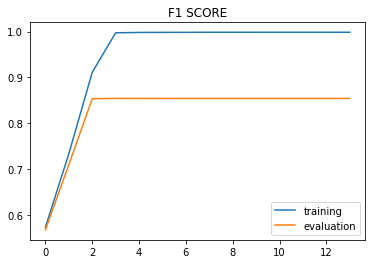

In [46]:
plt.title('F1 SCORE')
plt.plot(history.history['f1_score'], label='training')
plt.plot(history.history['val_f1_score'], label='evaluation')
plt.legend()
plt.show()

In [47]:
model = load_model("model05_CNN.h5")

In [48]:
accr = model.evaluate(X_eval, Y_eval)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

4435/4435 [==============================] - 20s 4ms/step - loss: 0.0065 - f1_score: 0.9238
Test set
  Loss: 0.006
  Accuracy: 0.924


# 예측

In [31]:
seq = tokenizer.texts_to_sequences(test_text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
pred = model.predict(padded)

In [33]:
temp = [np.argmax(i) for i in pred]

In [34]:
results = np.reshape(temp, (test.shape[0], ))

In [35]:
results[np.where(np.max(pred, axis=1) < 0.9)] = 7

In [36]:
# 기준 0.90
submission['level']=results
submission.value_counts()

level
0        998644
1        395409
3         12917
5          6355
7          5516
2            34
4            34
6             7
dtype: int64

In [37]:
# submission.to_csv('./submission/')

# 검증

In [38]:
valid_seq = tokenizer.texts_to_sequences(valid_text)
valid_padded = pad_sequences(valid_seq, maxlen=MAX_SEQUENCE_LENGTH)
valid_pred = model.predict(valid_padded)

In [39]:
valid_temp = [np.argmax(i) for i in valid_pred]
valid_results = np.reshape(valid_temp, (3, ))
valid_results[np.where(np.max(valid_pred, axis=1) < 0.9)] = 7
valid_results

array([1, 5, 0])